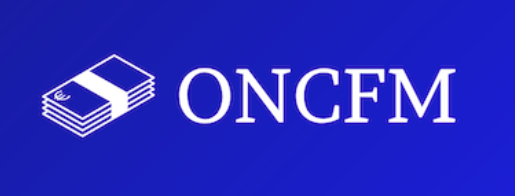

L'ONCFM renforce ses méthodes d’identification de faux billets.  
Objectifs :  
- mettre en place un algorithme capable de différencier les vrais billets des faux,  
- les vrais billets sont différenciés des faux  à partir de leurs caractéristiques géométriques.      

6 informations géométriques sur les billets (en mm) :
- length : longueur du billet,
- height_left : hauteur du billet (mesurée sur la gauche),
- height_right : hauteur du billet (mesurée sur la droite),
- margin_up : marge entre le bord supérieur du billet et l'image,
- margin_low : marge entre le bord inférieur du billet et l'image,
- diagonal : diagonale du billet.

*Charte graphique* :         
- 0 = true (vrai billet) en orange     
- 1 = false (faux billet) en bleu     

#### Introduction

In [44]:
# Standard library imports
from datetime import datetime as dt

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

import numpy as np
import os, sys
import pandas as pd
import re 
from scipy.stats import t, shapiro
import seaborn as sns

#from yellowbrick.features import ParallelCoordinates 
#Kelbowvisualiser, silouette

from sklearn import decomposition, preprocessing, cluster, metrics, neighbors, model_selection
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
# Régression Logistique
from sklearn.linear_model import LinearRegression, LogisticRegression
# Matrice de confusion
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.metrics import precision_recall_fscore_support as score 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [45]:
#affichage des versions des librairies
!python --version
print('\n'.join(f'{m.__name__} - {m.__version__}'
for m in globals().values() 
if getattr(m, '__version__', None)))

Python 3.9.12
numpy - 1.21.5
pandas - 1.4.2
re - 2.2.1
seaborn - 0.11.2
statsmodels - 0.13.2
statsmodels.api - 0.13.2


In [46]:
df_billets = pd.read_csv("../Documents/DAN-P10-data/billets.csv", sep=";")

#### I/-Inspection du Dataset      

##### I/-A/- Exploration du Dataset

In [47]:
# Affichage d'info, head et describe pour le même dataframe à la suite.
def analysis_df_start(df_input):
    df_input.info()
    display(df_input.head(5))
    display(df_input.isna().mean())
    display(df_input.isna().sum())
    display(df_input.describe(include="all"))

analysis_df_start(df_billets)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


is_genuine      0.000000
diagonal        0.000000
height_left     0.000000
height_right    0.000000
margin_low      0.024667
margin_up       0.000000
length          0.000000
dtype: float64

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500,1500.000000,1500.000000,1500.000000,1463.000000,1500.000000,1500.00000
unique,2,NaN,NaN,NaN,NaN,NaN,NaN
top,True,NaN,NaN,NaN,NaN,NaN,NaN
freq,1000,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,171.958440,104.029533,103.920307,4.485967,3.151473,112.67850
std,NaN,0.305195,0.299462,0.325627,0.663813,0.231813,0.87273
min,NaN,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,NaN,171.750000,103.820000,103.710000,4.015000,2.990000,112.03000
50%,NaN,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,NaN,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000


In [48]:
# Indication des valeurs que prennent la variable "is_genuine"
df_billets['is_genuine'].value_counts()

True     1000
False     500
Name: is_genuine, dtype: int64

In [49]:
# Remplacement de False par 1 et True par 0 pour travailler plus facilement avec un "int" au lieu d'une "str".
df_billets['is_genuine'].replace([False,True], [1,0], inplace=True)

<Figure size 72x72 with 0 Axes>

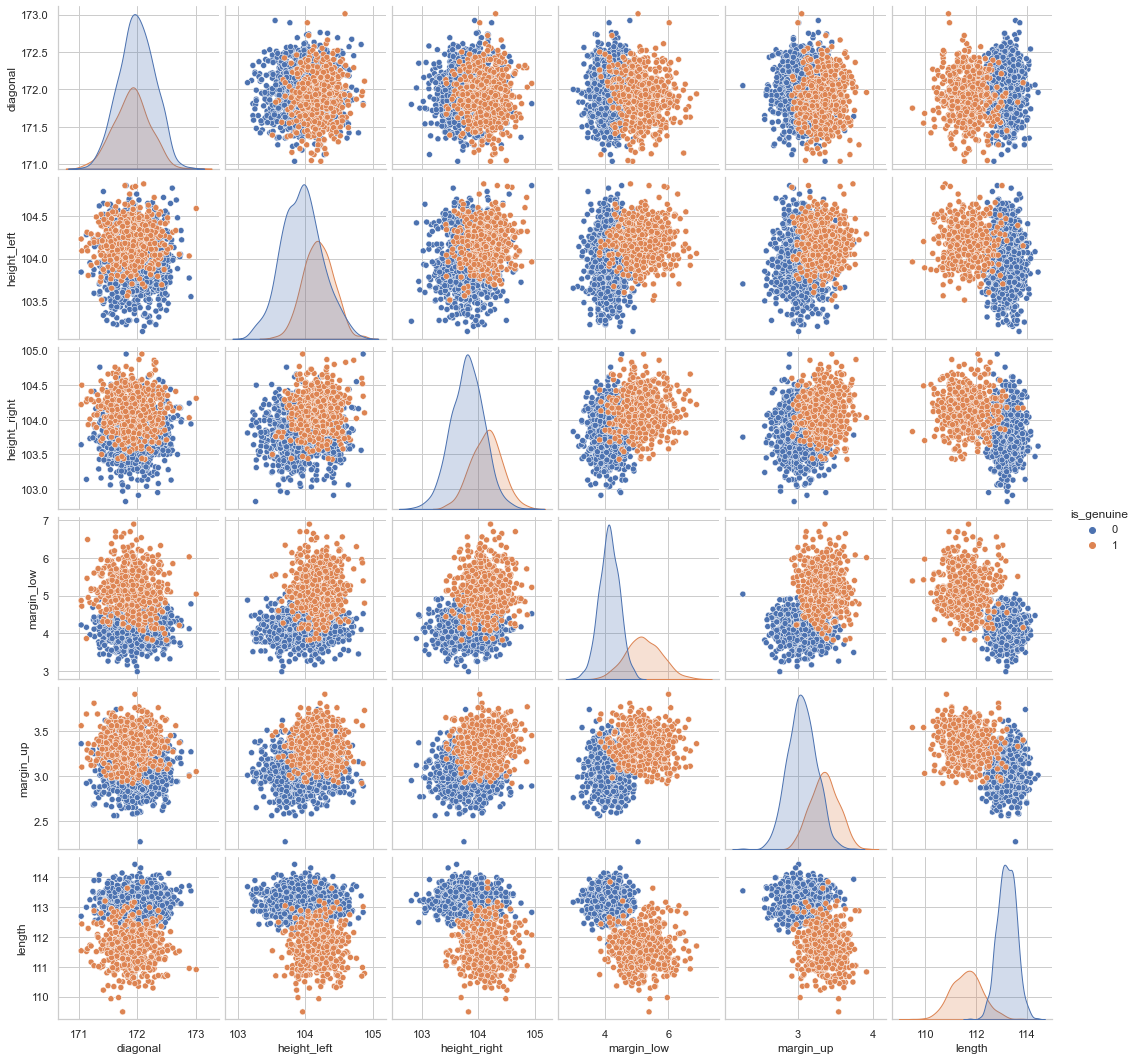

In [50]:
plt.figure(figsize=(1, 1))
sns.pairplot(df_billets, hue='is_genuine', corner=False)
plt.show()

In [51]:
def display_boxplots(df_billets):
    fig, ax = plt.subplots(figsize=(15,10))
    df_billets.boxplot(ax=ax)
    plt.xticks(rotation=90)
    plt.show()

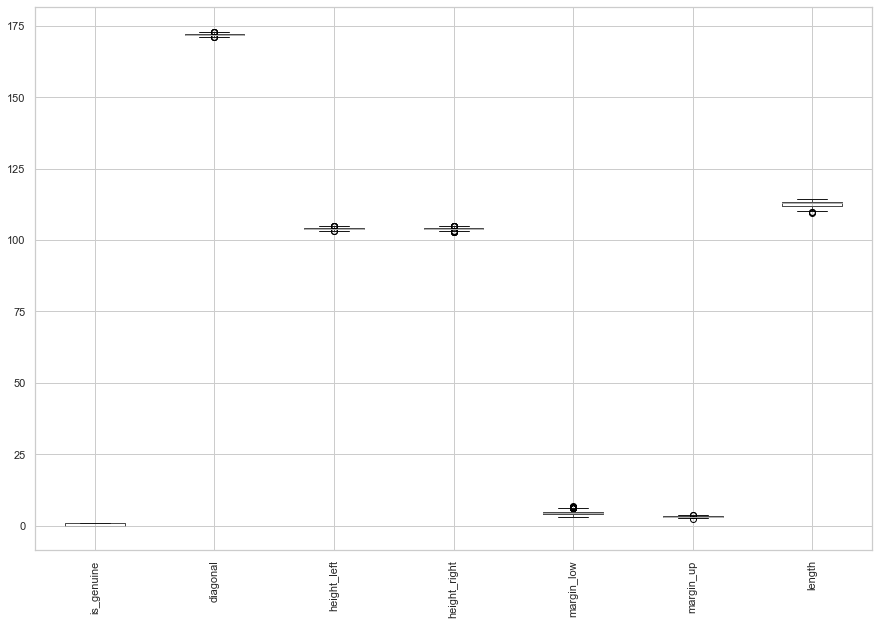

In [52]:
display_boxplots(df_billets)

<AxesSubplot:ylabel='height_left'>

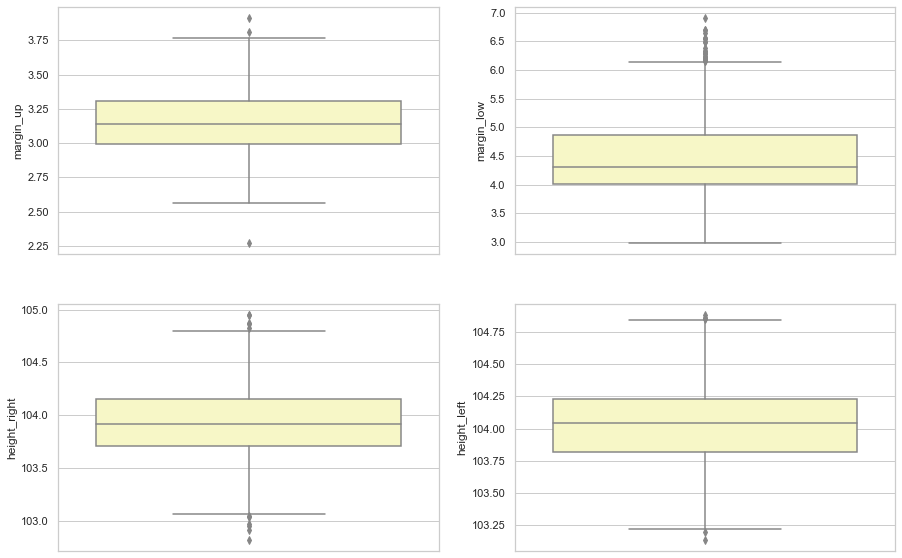

In [53]:
plt.figure(figsize=(15, 10))
sns.set(style="whitegrid")
plt.subplot(221)
sns.boxplot(data=df_billets,y='margin_up', color="#ffffbf")
plt.subplot(222)
sns.boxplot(data=df_billets,y='margin_low', color="#ffffbf")
plt.subplot(223)
sns.boxplot(data=df_billets, y='height_right', color="#ffffbf")
plt.subplot(224)
sns.boxplot(data=df_billets, y='height_left', color="#ffffbf")


<AxesSubplot:ylabel='length'>

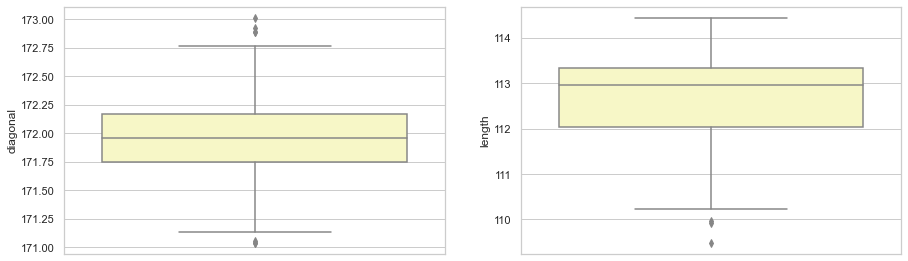

In [54]:
# Afficher des boxplot
plt.figure(figsize=(15, 10))
sns.set(style="whitegrid")
plt.subplot(221)
sns.boxplot(data=df_billets,y='diagonal', color="#ffffbf")
plt.subplot(222)
sns.boxplot(data=df_billets,y='length', color="#ffffbf")

Commentaires :   
- 37 valeurs manquantes pour la variable "margin_low",      
- les boîtes à moustaches montrent : 
    - des valeurs atypiques sur les variables (hormis "is_genuine"),   
    - que les moyennes de "height_left" et de "height_right" sont très proches et que celles de "margin_up" et de "margin_low" le sont aussi.  

In [55]:
# Vérification du nombre de faux billets
print("- Les vrais billets sont au nombre de",df_billets.loc[df_billets["is_genuine"]==True]["is_genuine"].count())
print("- Les faux billets sont au nombre de",df_billets.loc[df_billets["is_genuine"]==False]["is_genuine"].count())

- Les vrais billets sont au nombre de 500
- Les faux billets sont au nombre de 1000


##### I/-B/- Caractéristiques des faux billets

In [56]:
# Moyennes des variations (en %)

# var_diag
var_diag = (((df_billets.loc[df_billets["is_genuine"]==1]["diagonal"].mean())-(df_billets.loc[df_billets["is_genuine"]==0]["diagonal"].mean()))/(df_billets.loc[df_billets["is_genuine"]==0]["diagonal"].mean()))*100

# height
var_left = (((df_billets.loc[df_billets["is_genuine"]==1]["height_left"].mean())-(df_billets.loc[df_billets["is_genuine"]==0]["height_left"].mean()))/(df_billets.loc[df_billets["is_genuine"]==0]["height_left"].mean()))*100
var_right = (((df_billets.loc[df_billets["is_genuine"]==1]["height_right"].mean())-(df_billets.loc[df_billets["is_genuine"]==0]["height_right"].mean()))/(df_billets.loc[df_billets["is_genuine"]==0]["height_right"].mean()))*100

# margin
var_low = (((df_billets.loc[df_billets["is_genuine"]==1]["margin_low"].mean())-(df_billets.loc[df_billets["is_genuine"]==0]["margin_low"].mean()))/(df_billets.loc[df_billets["is_genuine"]==0]["margin_low"].mean()))*100
var_up = (((df_billets.loc[df_billets["is_genuine"]==1]["margin_up"].mean())-(df_billets.loc[df_billets["is_genuine"]==0]["margin_up"].mean()))/(df_billets.loc[df_billets["is_genuine"]==0]["margin_up"].mean()))*100

# var_length
var_length = (((df_billets.loc[df_billets["is_genuine"]==1]["length"].mean())-(df_billets.loc[df_billets["is_genuine"]==0]["length"].mean()))/(df_billets.loc[df_billets["is_genuine"]==0]["length"].mean()))*100

# Récapitulatif
pd.DataFrame(index=["Moyennes des variations (en %)"],columns=["diagonal","height_left","height_right","margin_low","margin_up","length"],data=[[var_diag, var_left, var_right, var_low, var_up, var_length]])


,diagonal,height_left,height_right,margin_low,margin_up,length
Moyennes des variations (en %),-0.049957,0.232046,0.32268,26.720415,9.764656,-1.388477


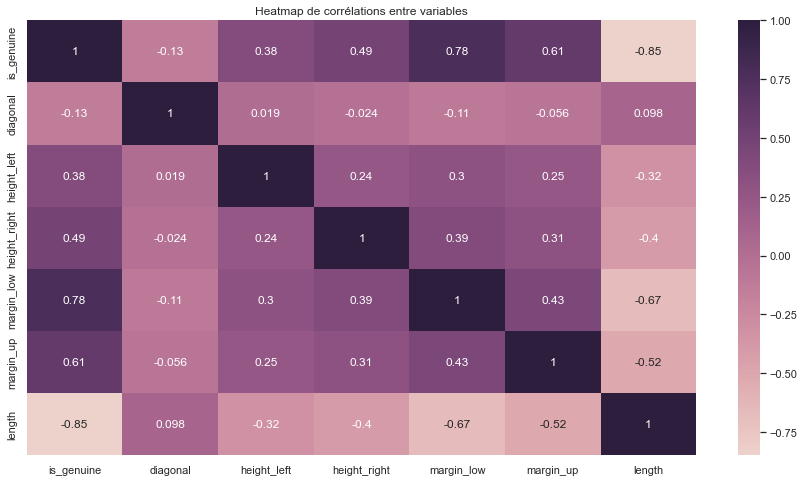

In [57]:
# Afficher la matrice de corrélation

plt.figure(figsize=(15,8))
plt.title("Heatmap de corrélations entre variables")
sns.heatmap(df_billets.corr(), annot=True,cmap=sns.cubehelix_palette(as_cmap=True))
plt.show()

Commentaires :   
- Corrélations entre billet "véritable" : et sa "longueur" de 0.85 et sa "diagonale" de 0.13.     
- Corrélations entre "margin_low" : et la "longueur" de - 0.67 et "véritable" de - 0.78. 
- Caractéristiques des vrais billets : une diagonale et une longueur plus grandes ; une hauteur et des marges moins grandes.

##### I/-C/- Prédiction valeurs manquantes

Prédiction des valeurs manquantes à l'aide de régression linéaire.

In [58]:
# Dataset avec margin_low = NaN
df_na = df_billets.loc[df_billets["margin_low"].isna()]

# Dataset sans valeurs manquantes
df_val = df_billets.dropna()

#### II/-Régression linéaire    

##### I/-A/- Régression linéaire multiple    

In [59]:
# Fonction de selection automatique du modele
# Source : https://www.kaggle.com/code/mustaphabouyardan/regression-lineaire-multiple
def backward_selected(data, response):
        remaining = set(data._get_numeric_data().columns)
        if response in remaining:
            remaining.remove(response)
        cond = True
        while remaining and cond:
            formula = "{} ~ {} + 1".format(response,' + '.join(remaining))
            print('_______________________________')
            print(formula)
            model = smf.ols(formula, data).fit()
            score = model.pvalues[1:]
            toRemove = score[score == score.max()]
            if toRemove.values > 0.05:
                print('remove', toRemove.index[0], '(p-value :', round(toRemove.values[0],3), ')')
                remaining.remove(toRemove.index[0])
            else:
                cond = False
                print('is the final model !')
            print('')
        print(model.summary())
        return model

In [60]:
columns = ['margin_low','diagonal','is_genuine','height_left','height_right','margin_up','length']
backward_selected = backward_selected(df_val[columns], 'margin_low')

_______________________________
margin_low ~ is_genuine + margin_up + height_right + height_left + diagonal + length + 1
remove length (p-value : 0.868 )

_______________________________
margin_low ~ is_genuine + margin_up + height_right + height_left + diagonal + 1
remove diagonal (p-value : 0.719 )

_______________________________
margin_low ~ is_genuine + margin_up + height_right + height_left + 1
remove height_right (p-value : 0.496 )

_______________________________
margin_low ~ is_genuine + margin_up + height_left + 1
remove height_left (p-value : 0.454 )

_______________________________
margin_low ~ is_genuine + margin_up + 1
is the final model !

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     1174.
Date:                

Commentaires :  
- Certains paramètres ne sont pas significativement différents de 0, leur p-valeur n'est pas inférieure à 5 %.    
- Le $R^{2}$ vaut environ 0.61, et le $R^{2}$ ajusté est d'environ 0.61.  
- On va conserver les variables significatives : is_genuine et margin_up  

In [61]:
df_fin= df_val.drop(['diagonal','length','height_right','height_left'],axis=1)

In [62]:
reg_multi = smf.ols('margin_low~is_genuine+margin_up ', data=df_fin).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     1174.
Date:                Sat, 12 Aug 2023   Prob (F-statistic):          1.24e-304
Time:                        16:46:29   Log-Likelihood:                -774.73
No. Observations:                1463   AIC:                             1555.
Df Residuals:                    1460   BIC:                             1571.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.7631      0.180     26.521      0.0

On remarque qu'à présent, tous les paramètres sont significatifs. Quant au $R^{2}$, il vaut environ 0.6, tout comme le $R^{2}$ ajusté.

*On peut donc utiliser ce modèle à des fins de prévision !*

3 hypothèses sont à vérifier afin de voir si une régression linéaire est envisageable :     
- Colinéarité : aucune corrélation linéaire entre les variables indépendantes (susceptibles d’agir sur la variable dépendante).   
- Homoscédasticité : la variance des résidus est constante dans le modèle de régression.        
- Normalité :    les résidus doivent suivre une distribution normale.

###### I/-A/-1- Vérifier la colinéarité des variables :   

In [63]:
variables = reg_multi.model.exog
[variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]
#source : COURS TP

[1.5938854494007748, 1.5938854494007746]

Ici, tous les coefficients sont inférieurs à 10, il n'y a donc pas de problème de colinéarité.


###### I/-A/-2- Testez l’homoscédasticité : la constance de la variance des résidus

In [64]:
_, pval, __, f_pval = statsmodels.stats.diagnostic.het_breuschpagan(reg_multi.resid, variables)
print('p value test Breusch Pagan:', pval)

p value test Breusch Pagan: 3.2033559115836335e-36


La p-valeur ici est inférieure à $5$%, on rejette l'hypothèse $H0$ selon laquelle les variances sont constantes (homoscédasticité).

Solutions potentielles :  
https://towardsdatascience.com/verifying-the-assumptions-of-linear-regression-in-python-and-r-f4cd2907d4c0  
- transformation logarithmique de la variable dépendante  
- en utilisant des modèles ARCH (hétéroscédasticité conditionnelle auto-régressive) pour modéliser la variance d'erreur. Un exemple pourrait être le marché boursier, où les données peuvent présenter des périodes de volatilité accrue ou réduite au fil du temps (groupement de volatilité, voir cet article pour plus d'informations)  
https://towardsdatascience.com/introduction-to-quantitative-finance-part-i-stylised-facts-of-asset-returns-5190581e40ea  

###### I/-A/-3- Testez la normalité des résidus

In [65]:
shapiro(reg_multi.resid)

ShapiroResult(statistic=0.9936248064041138, pvalue=6.20942773821298e-06)

Ici, l'hypothèse de normalité est remise en cause (p-value = 0.00 < 0.05).

Néanmoins, l'observation des résidus, le fait qu'ils ne soient pas très différents d'une distribution symétrique, et le fait que l'échantillon soit de taille suffisante (supérieure à 30) permettent de dire que **les résultats obtenus par le modèle linéaire gaussien ne sont pas absurdes**, même si le résidu n'est pas considéré comme étant gaussien.

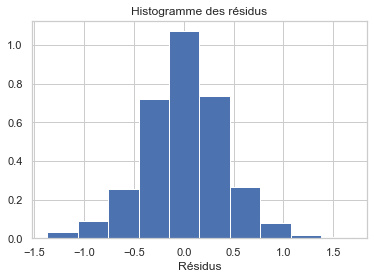

In [66]:
# création d'une colonne avec les résidus
df_fin['residu_s'] = reg_multi.resid
# affichage des résidus
plt.hist(df_fin['residu_s'], density=True)
plt.xlabel('Résidus')
plt.title('Histogramme des résidus')
plt.show()

Commentaire sur les résultats :  
- hypothèses vérifiées ...   
- hypothèse infirmée ...  
Section 5.1 + autre ressources 

In [67]:
# création de "df_pred" avec les 3 colonnes significatives 
# assignation à 'val pred' des valeurs de la régression linéaire multiple
# colonne df_na['margin_low_pred'] avec les valeurs de 'val_pred' 
df_pred = df_na.drop(['diagonal','height_left','height_right','length'], axis = 1)
val_pred = reg_multi.predict(df_pred)
df_na['margin_low_pred'] = val_pred

C:\Users\Matthieu\AppData\Local\Temp\ipykernel_34196\567879511.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_na['margin_low_pred'] = val_pred


In [68]:
# création de 'df_final' copie de 'df_billets'
# assignation des variables de 'margin_low_pred' aux valeurs manquantes
df_final = df_billets.copy()
df_final.loc[df_na.index, 'margin_low'] = df_na['margin_low_pred']

In [69]:
print("margin_low suite à la prédiction de la régression linéaire multiple")
display(df_final[["margin_low"]].describe())
print("margin_low avant la prédiction de la régression linéaire multiple")
display(df_billets[["margin_low"]].describe())

margin_low suite à la prédiction de la régression linéaire multiple


,margin_low
count,1500.000000
mean,4.482863
std,0.659849
min,2.980000
25%,4.027500
50%,4.310000
75%,4.870000
max,6.900000


margin_low avant la prédiction de la régression linéaire multiple


,margin_low
count,1463.000000
mean,4.485967
std,0.663813
min,2.980000
25%,4.015000
50%,4.310000
75%,4.870000
max,6.900000


Commentaire : les résultats de la prédiction semblent cohérents. On ne constate pas de décalage significatif depuis l'ajout des variables prédites par la régression linéaire.

#### III/- Prédictions

##### III/-A/- Régression logistique

In [70]:
df_reglog = df_final

In [71]:
# Définition de X et y 
y = df_reglog["is_genuine"]
X = df_reglog.drop(["is_genuine"], axis=1)

In [72]:
X_train, X_test, y_train, y_test = train_test_split(df_reglog, y, test_size=0.8, random_state=0)

In [73]:
# définition du modele
modele_rl =  LogisticRegression()

# entrainement du modele
modele_rl.fit(X_train,y_train)

# prédictions dans une variable y_predict_rl
y_predict_rl = modele_rl.predict(X_test)

# On vérifie le score de notre model sur les données Test (F1 score)
score_f1 = f1_score(y_test, y_predict_rl)
score_f1 = round(score_f1*100,4)
print("Le score du modèle de RL sur les données de test est de :", score_f1,"%")

Le score du modèle de RL sur les données de test est de : 99.7525 %


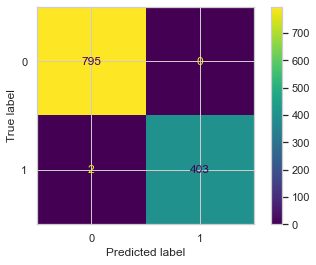

In [74]:
confusion_matrix_rl=confusion_matrix(y_test, y_predict_rl)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_rl)
disp.plot()
plt.show()
# Sources : ENI p. 421, https://github.com/emjako/pythondatascientist/blob/master/notebooks/06_01_Machine_learning_supervise.ipynb
# graph : hilpisch p 450

##### III/-B/- K-Means

In [75]:
# Création du df_kmeans pour les opérations K-Means
df_kmeans = df_final

In [76]:
# Définition des variables X et y
y = df_kmeans["is_genuine"]
X = df_kmeans.drop(["is_genuine"], axis=1)

In [77]:
X_train, X_test, y_train, y_test = train_test_split(df_kmeans, y, test_size=0.8, random_state=0)

In [78]:
# Objectif : déterminer le nombre optimal de clusters par la méthode du coude
# cluster_max : nombre maximal de clusters à tester
def my_kmeans_coude(df_kmeans, cluster_max=10, graphique=True):  
    inertia = []
    k_list = range(1, cluster_max)
    for k in k_list :
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(df_kmeans)
        inertia.append(kmeans.inertia_)
        
    # "optimal_index" = indice du nombre de clusters optimal
    optimal_index = np.argmin(np.diff(inertia)) + 1

    # Récupérer le nombre de clusters optimal
    n_clusters = optimal_index + 1
    print("Le nombre de cluster optimal est",n_clusters)
    return n_clusters

c:\Users\Matthieu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


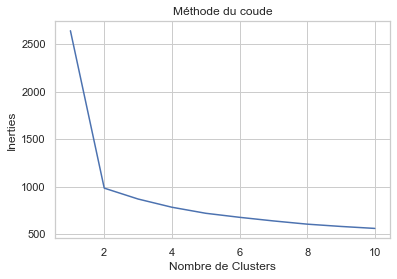

In [79]:
# Graph du coude pour trouver le nombre optimal de clusters
graph = []
intertie = {}
for i in range(1,11):
    km=KMeans(n_clusters=i)
    km.fit(df_kmeans)
    graph.append(km.inertia_)
    intertie[i] = km.inertia_
plt.plot(range(1,11), graph)
plt.title('Méthode du coude')
plt.xlabel('Nombre de Clusters')
plt.ylabel('Inerties')
plt.show()

In [80]:
# nombre optimal de clusters récupéré par la fonction my_kmeans_coude()
n_cluster = my_kmeans_coude(X_train, graphique=False)

c:\Users\Matthieu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Le nombre de cluster optimal est 2


In [81]:
# "model_km" = variable avec KMeans avec nb de clusters
model_km = KMeans(n_cluster)

In [82]:
# on entraîne 'model_km' sur le jeu de 'train'
model_km.fit(X_train)

KMeans(n_clusters=2)

In [83]:
# array 'prediction' = prédiction à partir de notre modèle
prediction = model_km.predict(X_test)

In [84]:
# création de colonne dans le df "X_test" avec les labels de "prediction"
X_test["cluster"] = prediction

In [85]:
# calcul du score du modèle 
score = f1_score(y_test, X_test["cluster"])
if score <0.5:
    X_test["cluster"].replace([0,1], [1,0], inplace=True)
    score = f1_score(y_test, X_test["cluster"])
    print("Le F1 score est de:",round(score*100,4),"%")
else : 
    print("Le F1 score est de:",round(score*100,4),"%")

Le F1 score est de: 98.8764 %


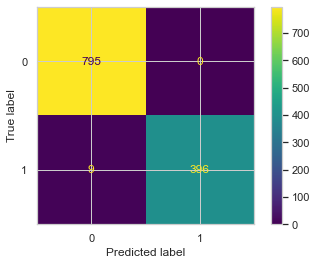

In [86]:
# matrice de confusion
cf = confusion_matrix(y_test, X_test.cluster)
cm = ConfusionMatrixDisplay(cf)
cm.plot()
plt.show()